# Flood mapping example
## Using sample data

In [1]:
import matplotlib.pyplot as plt, numpy as np, xarray
import algorithm

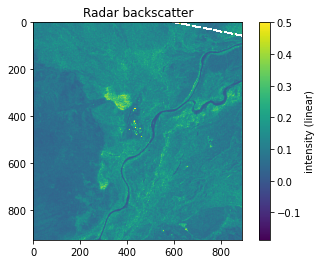

In [2]:
ds = xarray.open_dataset('example_data.nc').isel(time=0)

plt.imshow(ds.vv.data, vmax=0.5)
plt.title('Radar backscatter')
plt.colorbar().set_label('intensity (linear)')

/g/data1a/u46/users/brl654/MonashRadarWater/repo/notebooks/algorithm.py:496: RuntimeWarning: invalid value encountered in log10
  backscatter = np.log10(despeckle(backscatter)) * 10
/g/data1a/u46/users/brl654/MonashRadarWater/repo/notebooks/algorithm.py:506: RuntimeWarning: invalid value encountered in greater
  persistent = wofs > 0.8
/g/data1a/u46/users/brl654/MonashRadarWater/repo/notebooks/algorithm.py:507: RuntimeWarning: invalid value encountered in greater
  historic = wofs > 0.001
/g/data1a/u46/users/brl654/MonashRadarWater/repo/notebooks/algorithm.py:508: RuntimeWarning: invalid value encountered in less
  lowlying = hand < 20
/g/data1a/u46/users/brl654/MonashRadarWater/repo/notebooks/algorithm.py:428: RuntimeWarning: divide by zero encountered in double_scalars
  enhance = 4 * (C / HO)**2
/g/data1a/u46/users/brl654/MonashRadarWater/repo/notebooks/algorithm.py:429: RuntimeWarning: divide by zero encountered in double_scalars
  attenuate = 4 * (C / HNO)**2


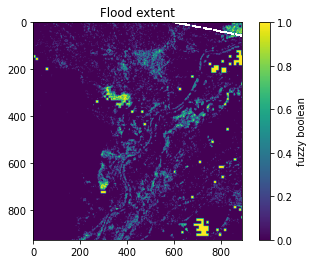

In [3]:
result = algorithm.classify(ds.vv.data, ds.wofs.data, ds.hand.data, ds.landcover.data, True)

plt.imshow(result)
plt.title('Flood extent')
plt.colorbar().set_label('fuzzy boolean')

## Using data through Digital Earth Australia
WOfS is sourced through the production DEA index. SAR is sourced through a beta DEA index. HAND and Landcover (DLCD) are sourced through the local NCI filesystem. The Open Data Cube API is utilised in each request, to extract the region of interest and to stack all layers consistently.

In [4]:
import datacube.testutils.io

prodcube = datacube.Datacube()
sarcube = datacube.Datacube(config={'db_hostname': 'agdcdev-db.nci.org.au',
                                    'db_port': 6432,
                                    'db_database': 'radar_test'})

Confirm that SAR data is available for the period and region of interest:

In [5]:
#lat, lon = -27.1544, 149.0677 # surat
#lat, lon = -28.034167, 148.581667 # st george
lat, lon = -18.1975, 125.56766 # Fitzroy Crossing

radius = 0.2

In [6]:
query = dict(product='s1_gamma0_scene',
             time=('2017-02-11', '2017-02-12'),
             lat=(lat-radius,lat+radius),
             lon=(lon-radius,lon+radius))
len(sarcube.find_datasets(**query)) # Count potential scenes

2

/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


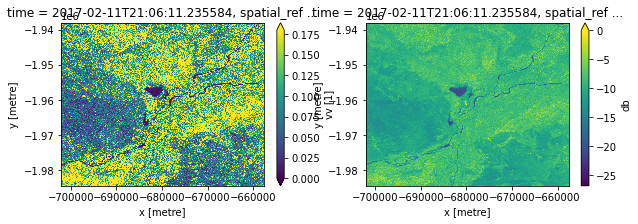

In [7]:
radar = sarcube.load(**query, group_by='solar_day').isel(time=0) # retrieve raster data
radar['db'] = (radar.vv.dims, 10 * np.log10(algorithm.despeckle(radar.vv.data))) # apply prefiltering

# visualise
fig, axes = plt.subplots(ncols=2, figsize=(10,3))
radar.vv.plot(vmin=0, vmax=0.18, ax=axes[0])
radar.db.plot(vmax=0, ax=axes[1])

Load other ancilliary products (Water Observations from Space, Height Above Nearest Drainage, and Dynamic Land Cover Dataset):

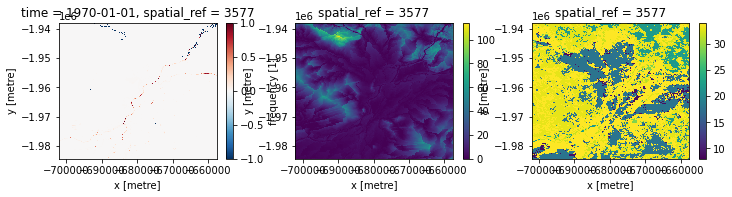

In [8]:
wofs = prodcube.load(product='wofs_summary', lat=query['lat'], lon=query['lon']).isel(time=0)
hand = datacube.testutils.io.rio_slurp_xarray("HANDpysheds1000_Albers25m.tif", gbox=radar.geobox)
lc = datacube.testutils.io.rio_slurp_xarray("LC_2011_FitzroyCatch_Albers25m.tif", gbox=radar.geobox)

# visualise
fig, axes = plt.subplots(ncols=3, figsize=(12,2.5)) # display in the same row
wofs.frequency.plot(ax=axes[0])
hand.plot(ax=axes[1])
lc.plot(ax=axes[2])

Apply the flood detection algorithm:

/g/data1a/u46/users/brl654/MonashRadarWater/repo/notebooks/algorithm.py:428: RuntimeWarning: divide by zero encountered in double_scalars
  enhance = 4 * (C / HO)**2
/g/data1a/u46/users/brl654/MonashRadarWater/repo/notebooks/algorithm.py:429: RuntimeWarning: divide by zero encountered in double_scalars
  attenuate = 4 * (C / HNO)**2


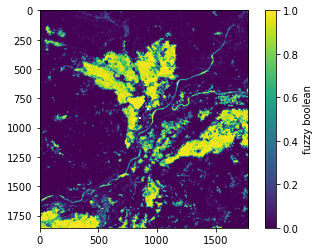

In [9]:
result = algorithm.classify(radar.db.data, wofs.frequency.data, hand.data, lc.data)

plt.imshow(result)
plt.colorbar().set_label('fuzzy boolean')